TODO:
* ~~move GRS stuff to its own class~~
  * ~~double check i'm getting concentrations at the right coordinates~~
  * ~~double check volatile normalization~~
  * ~~double check plotting~~
* ~~data downloader~~
* come up with a crater class

---
# 0. Setup

## Add path to source

In [1]:
## This is OD way to deal with paths

def joinPath(args):
    import os
    args = [os.getcwd() if arg == 'current' else arg]
    return os.path.abspath(os.path.join(*args))

    
def path_addSrc(fullpath_src = None, relpath_src = None, parent = False, verbose = False):
    """
    Add directory "src/" to path.
        
    PARAMETERS:
        fullpath_src : string
            Path to source from root.
        relpath_src : string
            Path to source from directory of current file.
        parent : boolean
            Use parent folder as source
        verbose : boolean
            Prints source directory path.
    
    RETURN:
        path_src : string
            Path to source from root.
    """
    
    import sys
    import os

    if fullpath_src:
        path_src = os.path.abspath(fullpath_src)
    elif relpath_src:
        path_src = os.path.abspath(os.path.join(os.getcwd(), relpath_src))
    elif parent:
        path_src = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
        
    if verbose: print("Path to source: " + path_src)
    
    sys.path.append(path_src)
    return path_src

In [2]:
path_src = path_addSrc(parent=True, verbose=True)

Path to source: /home/lain/sync/01_Research/Mars_Magnetics/code/05_mag_src_map/src


## Download data

In [3]:
from lib.DataDownloader import DataDownloader as dd

dd.download_folder(path_src=path_src, url="https://drive.google.com/drive/u/0/folders/1TF29m-zZGOpxP6kgpJiojLmVYRt3oF3t", overwrite=False)

Data folder already exists. To overwrite, add `overwrite=True` param.

Data folder contents: 
	README.txt
	craters
	GRS
	crustal_heat_flow


---
# 1. Analysis

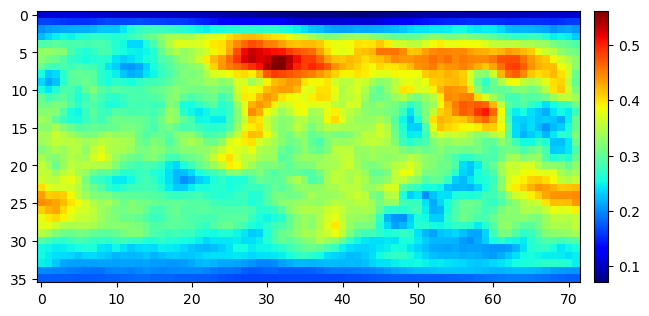

In [3]:
from lib.GRS import GRS as grs

GRS = grs(os.path.abspath(os.path.join(path_src, "data/GRS/")))
GRS.loadData()
GRS.visualize('k')

In [4]:
GRS.getConcentration(0,0,'k',normalized=True)

0.004308186917415633